STEP 1: BASIC DATA OVERVIEW
\nDataset size: 702 students × 14 variables
Graduation cohorts: 2020 to 2025
Number of districts: 3
District names: ['Riverbend ISD', 'Northview ISD', 'Lakeview ISD']
\================================================================================
STEP 2: DATA QUALITY ASSESSMENT
\nMissing values (NaN):
student_id                         0
district_name                      0
campus_name                        0
grad_cohort                        0
first_term_enrolled              236
enrollment_status                  0
college_type                     236
credits_earned_first_year          0
retained_next_year               236
industry_credential_after_hs     650
first_wage_record_date           668
loan_amount_first_year           236
scholarship_amount_first_year    236
grant_amount_first_year          236
dtype: int64
\String ''None'' values (not captured by .isnull()):
Series([], dtype: int64)
\Enrollment Status Distribution:
enrollment_status
Enrolle

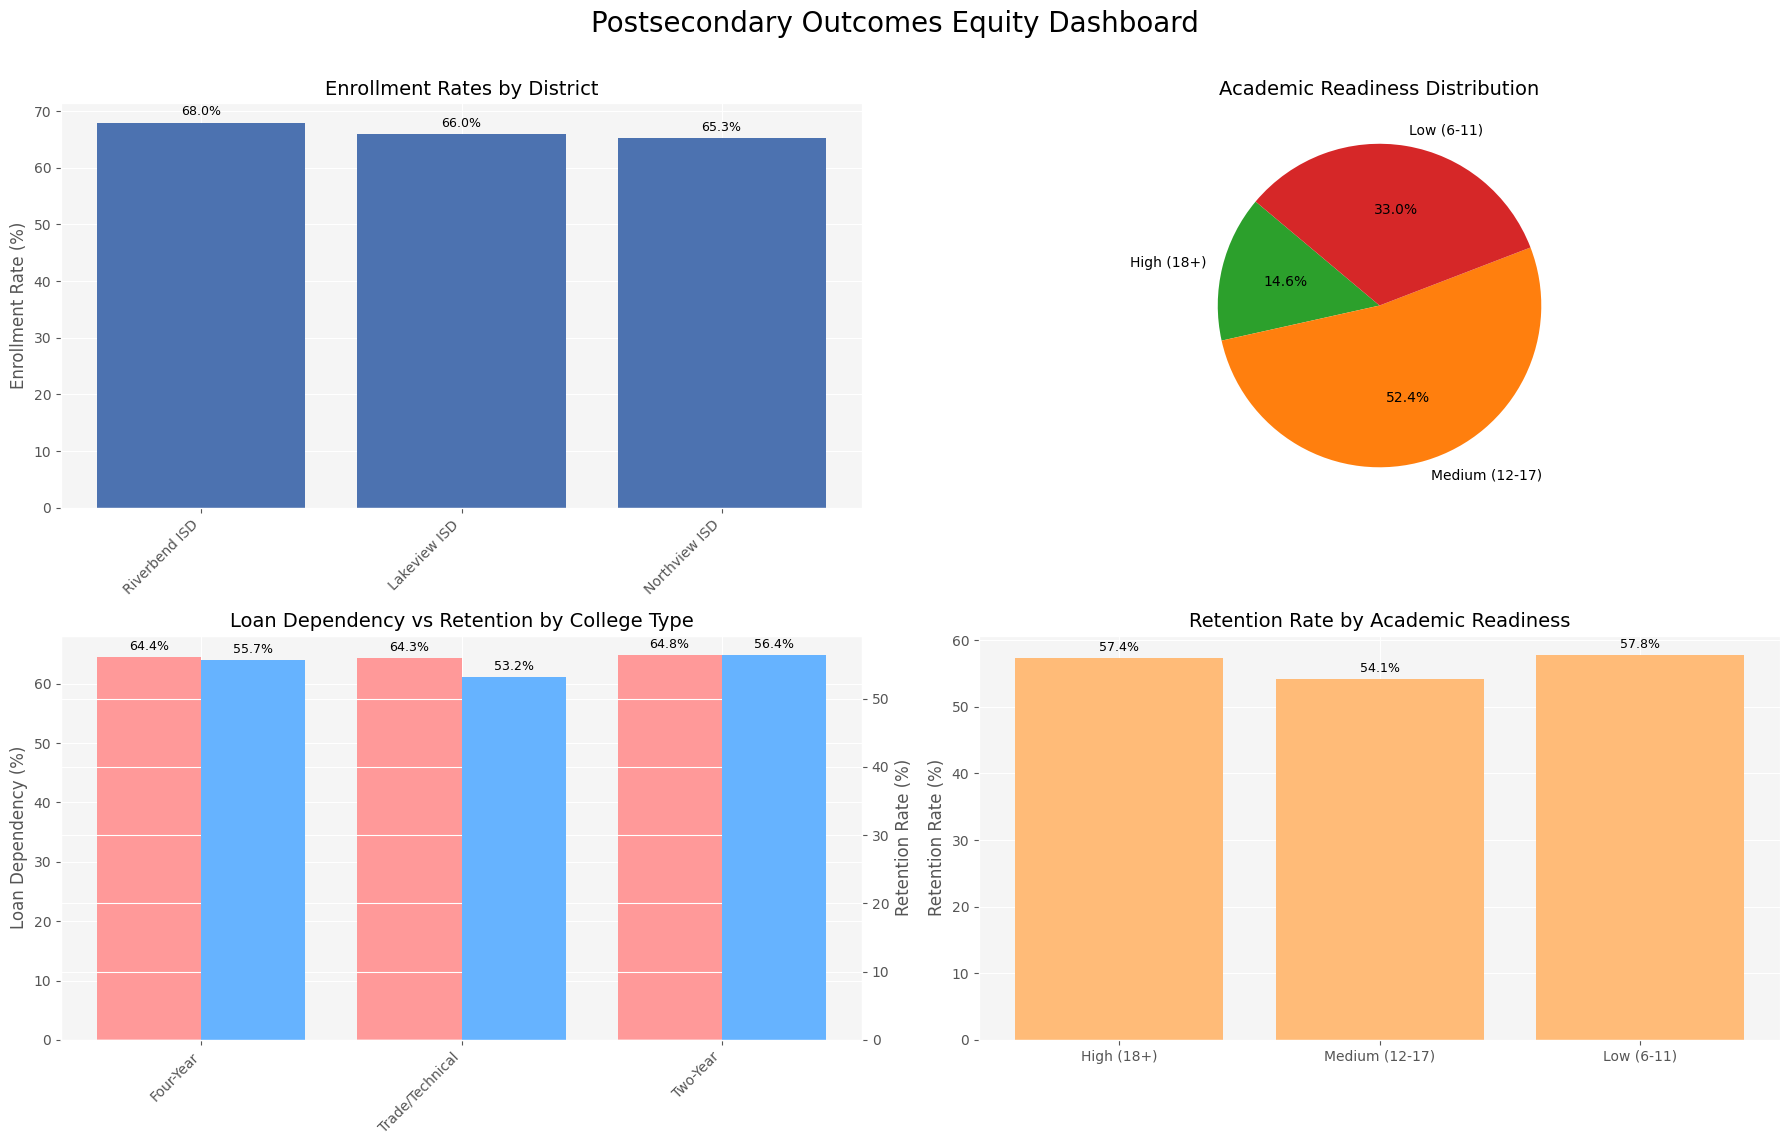

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12, 6)

plt.rcParams["axes.facecolor"] = "#f5f5f5"   
plt.rcParams["grid.color"] = "white"         
plt.rcParams["grid.linestyle"] = "-"         
plt.rcParams["axes.grid"] = True             
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.5

df = pd.read_csv("postsecondary_outcomes.csv")

print("=" * 80)
print("STEP 1: BASIC DATA OVERVIEW")
print("=" * 80)

print(f"\\nDataset size: {df.shape[0]:,} students × {df.shape[1]} variables")
print(f"Graduation cohorts: {df.grad_cohort.min()} to {df.grad_cohort.max()}")
print(f"Number of districts: {df.district_name.nunique()}")
print(f"District names: {list(df.district_name.unique())}")

print("\\" + "=" * 80)
print("STEP 2: DATA QUALITY ASSESSMENT") 
print("=" * 80)

print("\\nMissing values (NaN):")
print(df.isnull().sum())

print("\\String ''None'' values (not captured by .isnull()):")
none_counts = (df == "None").sum()
print(none_counts[none_counts > 0])

print("\\Enrollment Status Distribution:")
print(df.enrollment_status.value_counts())
print(f'Overall enrollment rate: {(df.enrollment_status == "Enrolled").mean() * 100:.1f}%')

print("\\" + "=" * 80)
print("STEP 3: DATA CLEANING")
print("=" * 80)

df_clean = df.copy()

print("\\  ISSUE: Inconsistent college_type values")
print(df_clean.college_type.value_counts())

college_mapping = {
    "4yr": "Four-Year",
    "4-year": "Four-Year", 
    "2yr": "Two-Year",
    "Two-Year": "Two-Year",
    "CC": "Two-Year",
    "community college": "Two-Year",
    "trade": "Trade/Technical",
    "None": None
}

df_clean["college_type_clean"] = df_clean.college_type.map(college_mapping)
print("\\ FIXED: Standardized college types")
print(df_clean.college_type_clean.value_counts(dropna=False))

for col in ["first_term_enrolled", "industry_credential_after_hs", "first_wage_record_date"]:
    df_clean[col] = df_clean[col].replace("None", None)
print("\\ FIXED: Converted string ''None'' to actual NaN values")

df_clean["is_retained"] = df_clean.retained_next_year.map({"Y": True, "N": False, "None": None})
df_clean["has_credential"] = df_clean.industry_credential_after_hs.map({"Y": True, None: False})  
df_clean["is_enrolled"] = df_clean.enrollment_status == "Enrolled"

print("\\ FIXED: Created boolean flags (True/False)")
print(f"   - is_enrolled: {df_clean.is_enrolled.sum()} students")
print(f"   - is_retained: {df_clean.is_retained.sum()} students")
print(f"   - has_credential: {df_clean.has_credential.sum()} students")

df_clean["total_aid"] = (
    df_clean.loan_amount_first_year.fillna(0) +
    df_clean.scholarship_amount_first_year.fillna(0) + 
    df_clean.grant_amount_first_year.fillna(0)
)

all_nan_mask = (df_clean.loan_amount_first_year.isna() & 
                df_clean.scholarship_amount_first_year.isna() &
                df_clean.grant_amount_first_year.isna())
df_clean.loc[all_nan_mask, "total_aid"] = np.nan

print("\\ CREATED: total_aid (sum of loans + scholarships + grants)")

df_clean["loan_dependency"] = (
    df_clean.loan_amount_first_year / df_clean.total_aid * 100
).round(1)

print(" CREATED: loan_dependency (% of aid that is loans)")

def categorize_readiness(credits):
    if pd.isna(credits) or credits == 0:
        return "Not Enrolled"
    elif credits < 6:
        return "Very Low (< 6)"
    elif credits < 12:
        return "Low (6-11)" 
    elif credits < 18:
        return "Medium (12-17)"
    else:
        return "High (18+)"

df_clean["readiness_level"] = df_clean.credits_earned_first_year.apply(categorize_readiness)

print(" CREATED: readiness_level (categorized credit completion)")
print(df_clean.readiness_level.value_counts())

def categorize_campus(campus_name):
    if "Career" in campus_name or "CTE" in campus_name:
        return "Career/CTE"
    elif "Tech" in campus_name:
        return "Tech Academy"
    elif "Early College" in campus_name or "Collegiate" in campus_name:
        return "Early College"
    else:
        return "Comprehensive HS"

df_clean["campus_type"] = df_clean.campus_name.apply(categorize_campus)

print(" CREATED: campus_type (inferred from campus name)")
print(df_clean.campus_type.value_counts())

print("\\" + "=" * 80)
print(f" CLEANING COMPLETE: {len(df_clean)} students with {len(df_clean.columns)} variables")
print("=" * 80)

print("\\" + "=" * 80)
print("EQUITY LENS 1: ACCESS TO POSTSECONDARY EDUCATION")
print("=" * 80)

access_by_district = df_clean.groupby("district_name").agg({
    "student_id": "count",
    "is_enrolled": ["sum", "mean"]
}).round(3)

access_by_district.columns = ["total_students", "enrolled_count", "enrollment_rate"]
access_by_district["enrollment_rate_%"] = (access_by_district["enrollment_rate"] * 100).round(1)

print("\\Enrollment Rates by District:")
print(access_by_district.sort_values("enrollment_rate_%", ascending=False))

enrollment_gap = access_by_district["enrollment_rate_%"].max() - access_by_district["enrollment_rate_%"].min()
print(f"\\  ACCESS GAP: {enrollment_gap:.1f} percentage point difference between districts")

print("\\Enrollment Rates by Campus Type:")
access_by_campus = df_clean.groupby("campus_type").agg({
    "student_id": "count",
    "is_enrolled": "mean"
}).round(3)
access_by_campus["enrollment_rate_%"] = (access_by_campus["is_enrolled"] * 100).round(1)
access_by_campus = access_by_campus.sort_values("enrollment_rate_%", ascending=False)
print(access_by_campus)

print("\\" + "=" * 80)
print("EQUITY LENS 2: COLLEGE READINESS")  
print("=" * 80)

enrolled_students = df_clean[df_clean.is_enrolled].copy()

readiness_by_district = enrolled_students.groupby("district_name").agg({
    "credits_earned_first_year": ["mean", "median", "std"],
    "is_retained": "mean"
}).round(1)

readiness_by_district.columns = ["avg_credits", "median_credits", "std_credits", "retention_rate"]
readiness_by_district["retention_rate_%"] = (readiness_by_district["retention_rate"] * 100).round(1)

print("\\Academic Readiness by District:")
print(readiness_by_district)

print("\\Readiness Level Distribution (Enrolled Students):")
readiness_dist = enrolled_students.groupby("readiness_level").size()
readiness_order = ["High (18+)", "Medium (12-17)", "Low (6-11)", "Very Low (< 6)"]
readiness_dist = readiness_dist.reindex([r for r in readiness_order if r in readiness_dist.index])
print(readiness_dist)
print(f"\\Students earning < 12 credits: {enrolled_students[enrolled_students.credits_earned_first_year < 12].shape[0]} ({enrolled_students[enrolled_students.credits_earned_first_year < 12].shape[0]/len(enrolled_students)*100:.1f}%)")

print("\\" + "=" * 80)
print("EQUITY LENS 3: FINANCIAL AID & DEBT BURDEN")
print("=" * 80)

aid_by_district = enrolled_students.groupby("district_name").agg({
    "total_aid": "mean",
    "loan_amount_first_year": "mean",
    "scholarship_amount_first_year": "mean",
    "grant_amount_first_year": "mean",
    "loan_dependency": "mean"
}).round(0)

print("\\Financial Aid Equity by District:")
print(aid_by_district)

avg_loan_dep = enrolled_students.loan_dependency.mean()
print(f"\\ Average Loan Dependency: {avg_loan_dep:.1f}% of aid comes from loans")
print(f"   (Lower is better - means more grant/scholarship support)")

aid_by_college = enrolled_students.groupby("college_type_clean").agg({
    "total_aid": "mean",
    "loan_dependency": "mean",
    "is_retained": "mean"
}).round(1)
aid_by_college.columns = ["avg_total_aid", "loan_dependency_%", "retention_rate"]

print("\\Financial Aid by College Type:")
print(aid_by_college)

print("\\" + "=" * 80)
print("EQUITY LENS 4: EARLY POSTSECONDARY OUTCOMES")
print("=" * 80)

retention_by_readiness = enrolled_students.groupby("readiness_level").agg({
    "student_id": "count",
    "is_retained": lambda x: x.sum() / x.notna().sum() * 100
}).round(1)
retention_by_readiness.columns = ["student_count", "retention_rate_%"]

print("\\Retention by Academic Readiness:")
print(retention_by_readiness)

print(f"\\ Industry Credential Attainment:")
print(f"   Total students with credentials: {df_clean.has_credential.sum()}")
print(f"   Rate: {df_clean.has_credential.sum() / len(df_clean) * 100:.1f}%")

credential_by_district = df_clean.groupby("district_name").has_credential.mean() * 100
print(f"\\   By District:")
for district, rate in credential_by_district.items():
    print(f"   - {district}: {rate:.1f}%")

employed_students = df_clean[df_clean.first_wage_record_date.notna()]
print(f"\\ Employment Outcomes:")
print(f"   Students with wage records: {len(employed_students)} ({len(employed_students)/len(df_clean)*100:.1f}%)")

print("\\" + "=" * 80)
print("DATA EXPLORATION COMPLETE")
print("=" * 80)

df_clean


import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (18, 12)
plt.rcParams["axes.facecolor"] = "#f5f5f5"
plt.rcParams["grid.color"] = "white"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["axes.grid"] = True

access_by_district = df_clean.groupby("district_name").agg(
    total_students=("student_id", "count"),
    enrollment_rate=("is_enrolled", "mean")
).reset_index()
access_by_district["enrollment_rate_%"] = access_by_district["enrollment_rate"] * 100
access_by_district = access_by_district.dropna(subset=["enrollment_rate_%"])
access_by_district = access_by_district.sort_values("enrollment_rate_%", ascending=False)


enrolled_students = df_clean[df_clean.is_enrolled].copy()
readiness_order = ["High (18+)", "Medium (12-17)", "Low (6-11)", "Very Low (< 6)"]
readiness_counts = enrolled_students["readiness_level"].value_counts().reindex(readiness_order)
readiness_counts = readiness_counts.dropna()
readiness_counts = readiness_counts[readiness_counts > 0]

aid_by_college = enrolled_students.groupby("college_type_clean").agg(
    loan_dependency_pct=("loan_dependency", "mean"),
    retention_rate=("is_retained", "mean")
).reset_index()
aid_by_college = aid_by_college.dropna(subset=["loan_dependency_pct", "retention_rate"])
aid_by_college["retention_rate_%"] = aid_by_college["retention_rate"] * 100

retention_by_readiness = enrolled_students.groupby("readiness_level").agg(
    retention_rate_pct=("is_retained", lambda x: x.sum()/x.notna().sum()*100)
).reindex(readiness_order)
retention_by_readiness = retention_by_readiness.dropna()

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Postsecondary Outcomes Equity Dashboard", fontsize=20, y=0.95)


ax = axes[0,0]
bars = ax.bar(np.arange(len(access_by_district)), access_by_district["enrollment_rate_%"], color="#4C72B0")
ax.set_title("Enrollment Rates by District", fontsize=14)
ax.set_ylabel("Enrollment Rate (%)")
ax.set_xticks(np.arange(len(access_by_district)))
ax.set_xticklabels(access_by_district["district_name"], rotation=45, ha="right")
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)


ax = axes[0,1]
colors = ["#2ca02c", "#ff7f0e", "#d62728", "#9467bd"]
ax.pie(readiness_counts, labels=readiness_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
ax.set_title("Academic Readiness Distribution", fontsize=14)


ax1 = axes[1,0]
ax2 = ax1.twinx()
x = np.arange(len(aid_by_college))
width = 0.4
bars1 = ax1.bar(x - width/2, aid_by_college["loan_dependency_pct"], width, color="#ff9999", label="Loan Dependency %")
bars2 = ax2.bar(x + width/2, aid_by_college["retention_rate_%"], width, color="#66b3ff", label="Retention Rate %")
ax1.set_ylabel("Loan Dependency (%)")
ax2.set_ylabel("Retention Rate (%)")
ax1.set_xticks(x)
ax1.set_xticklabels(aid_by_college["college_type_clean"], rotation=45, ha="right")
ax1.set_title("Loan Dependency vs Retention by College Type", fontsize=14)
for bar in bars1:
    ax1.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0,3), textcoords='offset points', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax2.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0,3), textcoords='offset points', ha='center', va='bottom', fontsize=9)


ax = axes[1,1]
bars = ax.bar(retention_by_readiness.index, retention_by_readiness["retention_rate_pct"], color="#ffbb78")
ax.set_title("Retention Rate by Academic Readiness", fontsize=14)
ax.set_ylabel("Retention Rate (%)")
for bar in bars:
    ax.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0,3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()
